In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt


In [3]:
import sys
import os

# Calculate the project root (three levels up from this notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.house_price_predictor.model.estimators import ScikitLearnEstimator

In [5]:

# Set MLflow tracking URI (adjust port if needed)
mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("house-price-prediction")


<Experiment: artifact_location='mlflow-artifacts:/999115056584850357', creation_time=1748017556032, experiment_id='999115056584850357', last_update_time=1748017556032, lifecycle_stage='active', name='house-price-prediction', tags={}>

In [6]:
# Load processed train and test data
train_df = pd.read_parquet("../../../data/staged/train.parquet")
test_df = pd.read_parquet("../../../data/staged/test.parquet")
full_df = pd.read_parquet("../../../data/staged/full.parquet")

train_df["price"] = train_df["price"].astype("float64")
test_df["price"] = test_df["price"].astype("float64")

In [7]:


# Separate features and target
target = "price"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test: pd.Series = test_df[target]
#Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}
#Best cross-validation RMSE: $1,569,966.97
models = [
    LinearRegression(),
    RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error"),
    XGBRegressor(random_state=42),
    XGBRegressor(random_state=42,colsample_bytree=1.0, learning_rate= 0.1, max_depth= 2, n_estimators= 100, subsample= 0.6),
]
X_train

,area,bathrooms,stories,parking,bedrooms,airconditioning,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.298969,0.333333,1.000000,0.333333,0.4,1.0,0.0,1.0,0.0,0.0
1,0.381443,0.333333,0.000000,1.000000,0.4,1.0,0.0,0.0,1.0,0.0
2,0.148866,0.000000,0.000000,0.666667,0.2,1.0,0.0,1.0,0.0,0.0
3,0.065979,0.000000,0.333333,0.000000,0.4,0.0,1.0,0.0,0.0,1.0
4,0.144330,0.000000,0.333333,0.000000,0.4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
431,0.298969,0.333333,1.000000,0.000000,0.6,1.0,0.0,0.0,0.0,1.0
432,0.261168,0.333333,0.000000,0.000000,0.6,1.0,1.0,0.0,1.0,0.0
433,0.195876,0.333333,0.666667,0.333333,0.4,0.0,0.0,1.0,0.0,0.0
434,0.164261,0.000000,0.000000,0.000000,0.2,0.0,0.0,0.0,0.0,1.0


In [8]:
"""
X_full = full_df.drop(columns=[target])
y_full = full_df[target]
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1) # n_jobs=-1 for parallel processing
param_grid = {
    'n_estimators': [50,100, 200, 300, 500], # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage
    'max_depth': [2, 3, 5, 7], # Maximum depth of a tree
    'subsample': [0.6, 0.8, 1.0], # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0], # Subsample ratio of columns when constructing each tree
    # 'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
    # 'min_child_weight': [1, 5, 10], # Minimum sum of instance weight (hessian) needed in a child
    # 'reg_alpha': [0, 0.005, 0.01], # L1 regularization term on weights
    # 'reg_lambda': [1, 2, 5], # L2 regularization term on weights
}

# --- 5. Initialize GridSearchCV ---
# scoring: 'neg_mean_squared_error' is used because GridSearchCV tries to maximize the score.
#          A negative MSE is equivalent to minimizing MSE. We will convert it back to RMSE.
# cv: Number of cross-validation folds. 5-fold is a common choice.
# verbose: Higher values provide more details during the search.
# n_jobs: Number of CPU cores to use for GridSearchCV itself. -1 uses all available cores.
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # Maximize negative MSE (minimize MSE)
    cv=5, # 5-fold cross-validation
    verbose=2, # Prints progress
    n_jobs=-1 # Use all available cores for parallel search
)

print("\nStarting GridSearchCV...")
# --- 6. Fit GridSearchCV ---
# This will take some time depending on your grid size and data.
grid_search.fit(X_full, y_full) # Use scaled features

print("\nGridSearchCV Complete!")

# --- 7. Evaluate Results ---
print("\n--- Best Parameters and Score ---")
print(f"Best parameters found: {grid_search.best_params_}")
# The best score is negative MSE, so convert to RMSE
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best cross-validation RMSE: ${best_rmse:,.2f}")

# Get the best estimator (model)
best_xgb_model = grid_search.best_estimator_
"""

'\nX_full = full_df.drop(columns=[target])\ny_full = full_df[target]\nxgb_model = XGBRegressor(objective=\'reg:squarederror\', random_state=42, n_jobs=-1) # n_jobs=-1 for parallel processing\nparam_grid = {\n    \'n_estimators\': [50,100, 200, 300, 500], # Number of boosting rounds (trees)\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage\n    \'max_depth\': [2, 3, 5, 7], # Maximum depth of a tree\n    \'subsample\': [0.6, 0.8, 1.0], # Subsample ratio of the training instance\n    \'colsample_bytree\': [0.8, 1.0], # Subsample ratio of columns when constructing each tree\n    # \'gamma\': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition\n    # \'min_child_weight\': [1, 5, 10], # Minimum sum of instance weight (hessian) needed in a child\n    # \'reg_alpha\': [0, 0.005, 0.01], # L1 regularization term on weights\n    # \'reg_lambda\': [1, 2, 5], # L2 regularization term on weights\n}\n\n# --- 5. Initialize GridSearchCV ---\n# scoring: \'neg

In [9]:
def plot_stuff(X_test, y_test, model, estimator, y_pred):
    plt.figure(figsize=(8,4))
    plt.scatter(x=X_test["area"], y=y_test, label="Actual", alpha=0.5)
    plt.scatter(x=X_test["area"], y=y_pred, label="Predicted", alpha=0.5)
        
        #plt.hist(y_pred, bins=50, alpha=0.5, label="Predicted", color="blue")
        #plt.hist(y_test, bins=50, alpha=0.5, label="Actual", color="orange")
    print()
    plt.legend()
    plt.title(f"Scatterplot of {estimator.estimator_name} predictions")
        # Calculate prediction errors
    errors = (y_test - y_pred).abs()
        # Create and log error box plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot(errors)
    ax.set_title(f"Prediction Error Distribution for {model.__class__.__name__}")
    ax.set_ylabel("Error (Actual Price - Predicted Price)")
    ax.set_xticklabels([model.__class__.__name__]) # Label the box with model name
    plt.show(fig)
    return errors

Entrenando modelo de Scikit-learn: ScikitLearn - LinearRegression
Evaluando el modelo: ScikitLearn - LinearRegression


2025/05/23 17:02:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Logged metrics for ScikitLearn - LinearRegression
r2: 0.6244
mse: 1898619698762.5422
rmse: 1377904.0964
max_error: 4921809.3875
mape: 0.2206





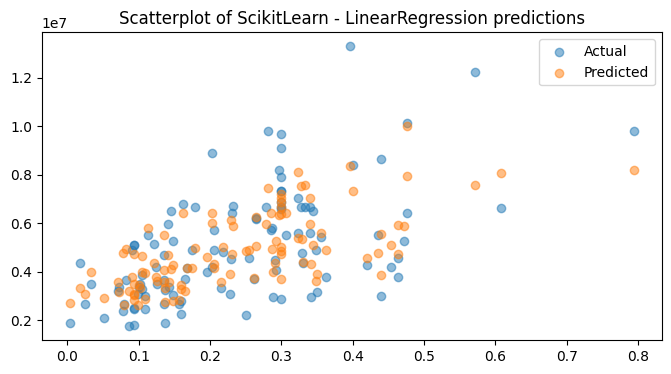

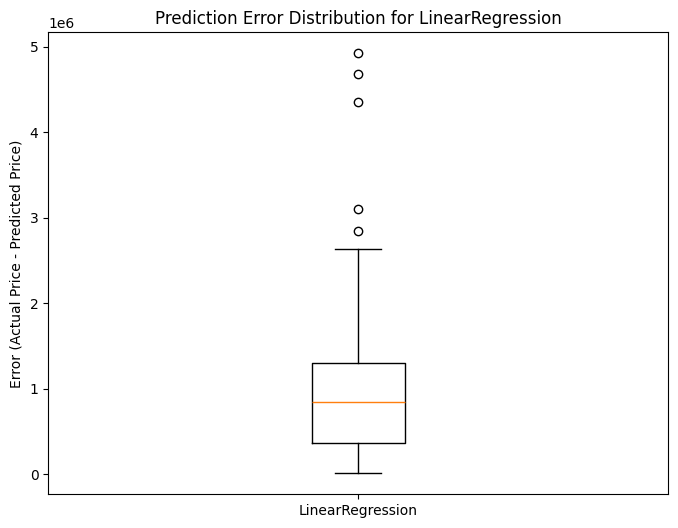


--- Top 10 Biggest Prediction Errors for LinearRegression (by absolute value) ---
     Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
88     13300000.0     8.378191e+06    4.921809e+06         37.006086
25     12250000.0     7.565352e+06    4.684648e+06         38.242022
104     9100000.0     4.750478e+06    4.349522e+06         47.796947
91      8645000.0     5.543620e+06    3.101380e+06         35.874837
15      2660000.0     5.502159e+06    2.842159e+06        106.848084
89      9681000.0     7.044858e+06    2.636142e+06         27.230060
79      2233000.0     4.855140e+06    2.622140e+06        117.426799
17      7350000.0     4.851972e+06    2.498028e+06         33.986776
101     8890000.0     6.435366e+06    2.454634e+06         27.611180
65      6510000.0     4.094905e+06    2.415095e+06         37.098230
----------------------------------------------------------------------
🏃 View run LinearRegression at: http://localhost:8080/#/experiments/999115056584850357/

2025/05/23 17:02:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Logged metrics for ScikitLearn - RandomForestRegressor
r2: 0.5927
mse: 2058868023106.3484
rmse: 1434875.6124
max_error: 5656140.0000
mape: 0.2224





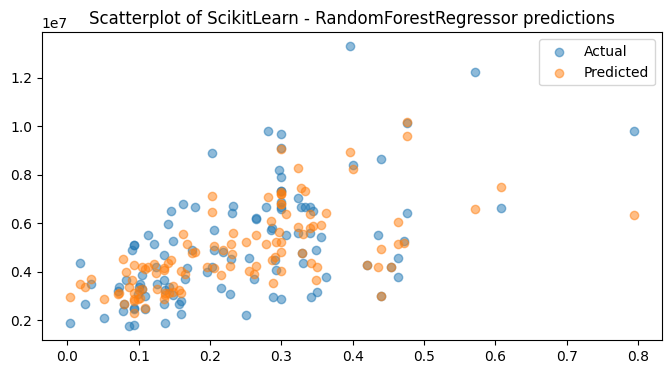

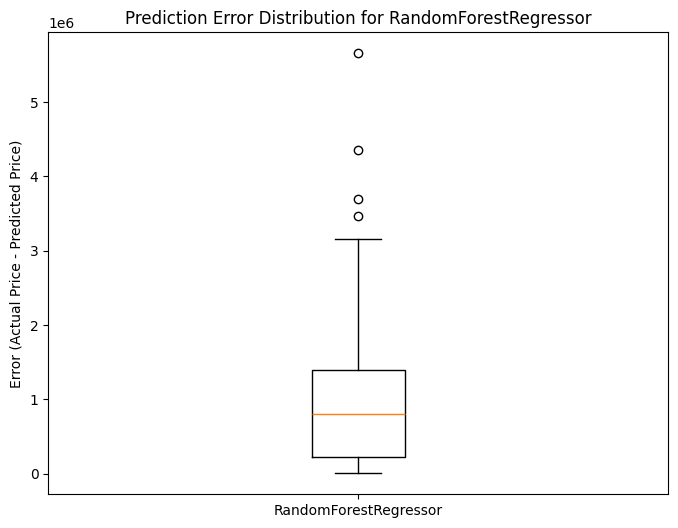


--- Top 10 Biggest Prediction Errors for RandomForestRegressor (by absolute value) ---
     Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
25     12250000.0        6593860.0       5656140.0         46.172571
88     13300000.0        8938984.6       4361015.4         32.789589
91      8645000.0        4944660.0       3700340.0         42.803239
28      9800000.0        6330310.0       3469690.0         35.405000
94      6440000.0        9597350.0       3157350.0         49.027174
79      2233000.0        5231940.0       2998940.0        134.300940
56      9800000.0        7080780.0       2719220.0         27.747143
105     3773000.0        6414275.0       2641275.0         70.004638
85      8190000.0        5630310.0       2559690.0         31.253846
104     9100000.0        6787270.0       2312730.0         25.414615
----------------------------------------------------------------------
🏃 View run RandomForestRegressor at: http://localhost:8080/#/experiments/999115056

2025/05/23 17:02:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Logged metrics for ScikitLearn - XGBRegressor
r2: 0.5598
mse: 2224941053892.5420
rmse: 1491623.6301
max_error: 6923362.5000
mape: 0.2305





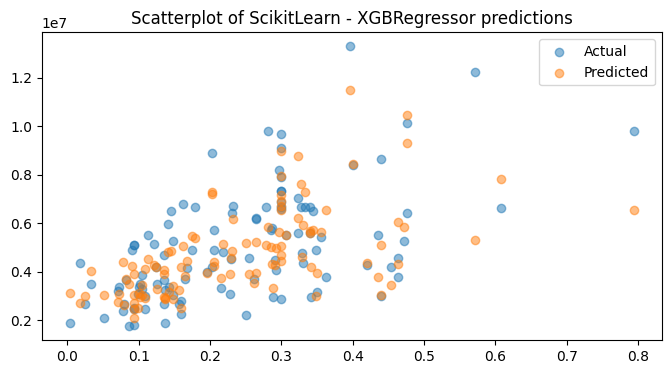

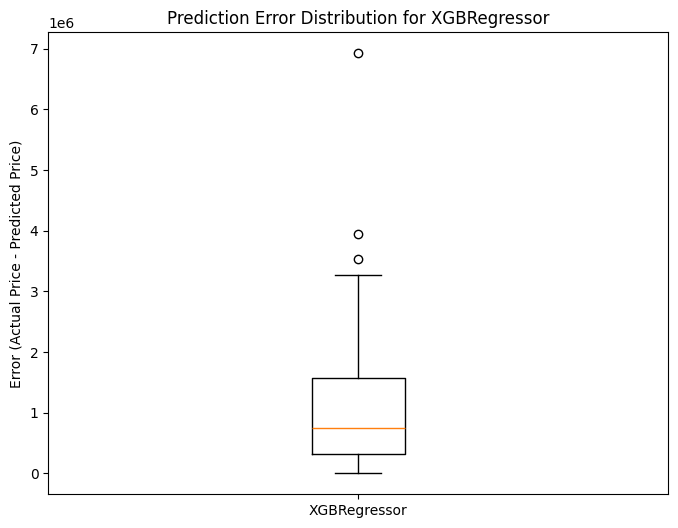


--- Top 10 Biggest Prediction Errors for XGBRegressor (by absolute value) ---
     Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
25     12250000.0       5326637.50      6923362.50         56.517245
56      9800000.0       5856920.00      3943080.00         40.235510
91      8645000.0       5117821.00      3527179.00         40.800220
28      9800000.0       6535396.50      3264603.50         33.312281
35      4200000.0       7203615.00      3003615.00         71.514643
79      2233000.0       5195122.00      2962122.00        132.652127
94      6440000.0       9311587.00      2871587.00         44.589860
105     3773000.0       6561629.50      2788629.50         73.910138
67      5110000.0       2473758.25      2636241.75         51.589858
85      8190000.0       5647391.50      2542608.50         31.045281
----------------------------------------------------------------------
🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/999115056584850357/runs/5f2

2025/05/23 17:02:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Logged metrics for ScikitLearn - XGBRegressor
r2: 0.6314
mse: 1863303750883.4031
rmse: 1365028.8462
max_error: 5923244.0000
mape: 0.2139





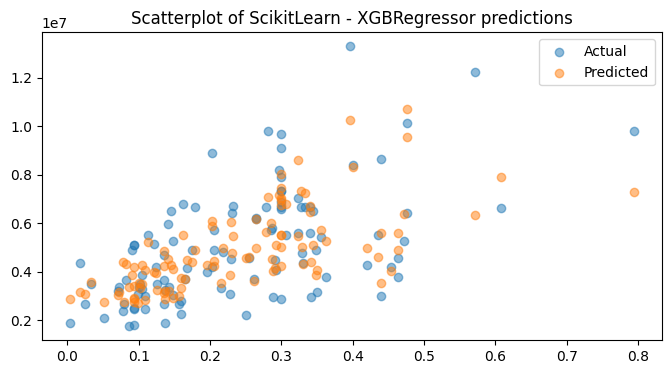

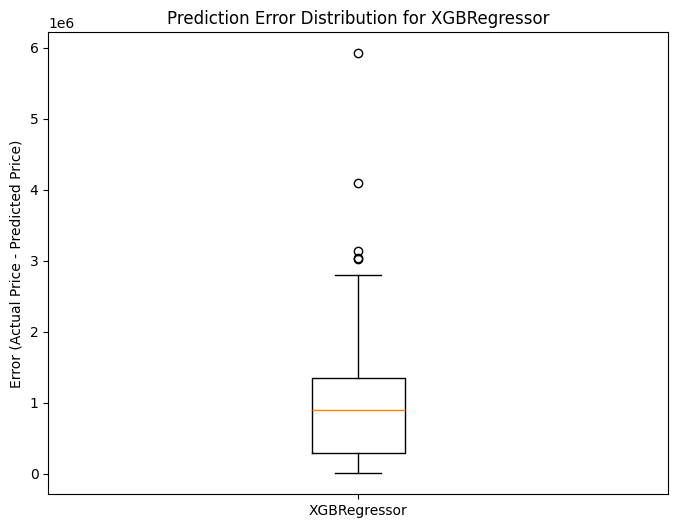


--- Top 10 Biggest Prediction Errors for XGBRegressor (by absolute value) ---
     Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
25     12250000.0        6326756.0       5923244.0         48.353012
104     9100000.0        4999702.0       4100298.0         45.058220
94      6440000.0        9575582.0       3135582.0         48.689161
88     13300000.0       10255400.0       3044600.0         22.891729
91      8645000.0        5614259.5       3030740.5         35.057727
101     8890000.0        6090272.0       2799728.0         31.493003
56      9800000.0        7080938.5       2719061.5         27.745526
28      9800000.0        7281967.0       2518033.0         25.694214
79      2233000.0        4559612.0       2326612.0        104.192208
65      6510000.0        4270096.5       2239903.5         34.407120
----------------------------------------------------------------------
🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/999115056584850357/runs/09a

In [10]:
for model in models:
    with mlflow.start_run(run_name=model.__class__.__name__):
        estimator = ScikitLearnEstimator(model)
        estimator.train(X_train, y_train)
        y_pred: pd.Series = estimator.predict(X_test)
        metrics = estimator.evaluate(y_test, y_pred)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model",)
        print(f"\nLogged metrics for {estimator.estimator_name}")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
        print()

        print()
        errors = plot_stuff(X_test, y_test, model, estimator, y_pred)

        # Create a DataFrame for detailed error analysis
        error_details_df = pd.DataFrame({
            'Actual_Price': y_test,
            'Predicted_Price': y_pred,
            'Absolute_Error': errors,
            'Percentage_Error': (errors / y_test) * 100
        })

        # Sort by absolute error in descending order and get top 10
        top_10_biggest_errors = error_details_df.sort_values(by='Absolute_Error', ascending=False).head(10)

        print(f"\n--- Top 10 Biggest Prediction Errors for {model.__class__.__name__} (by absolute value) ---")
        print(top_10_biggest_errors.to_string()) # .to_string() ensures the full DataFrame is printed
        print("-" * 70) # Separator line
    
    
# Save the model

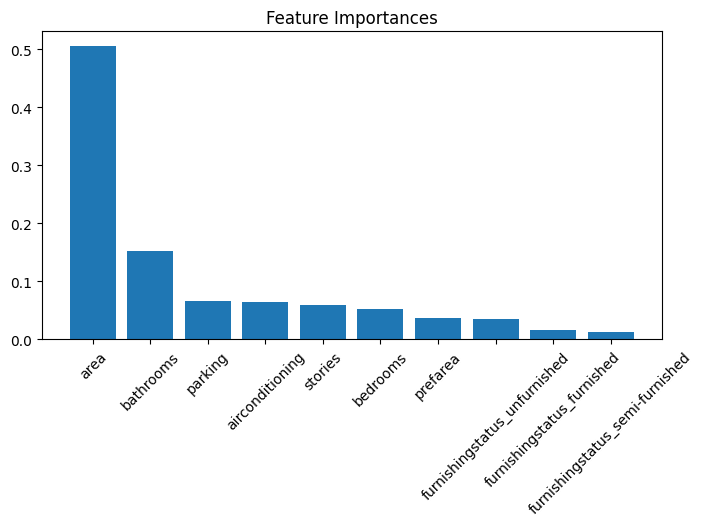

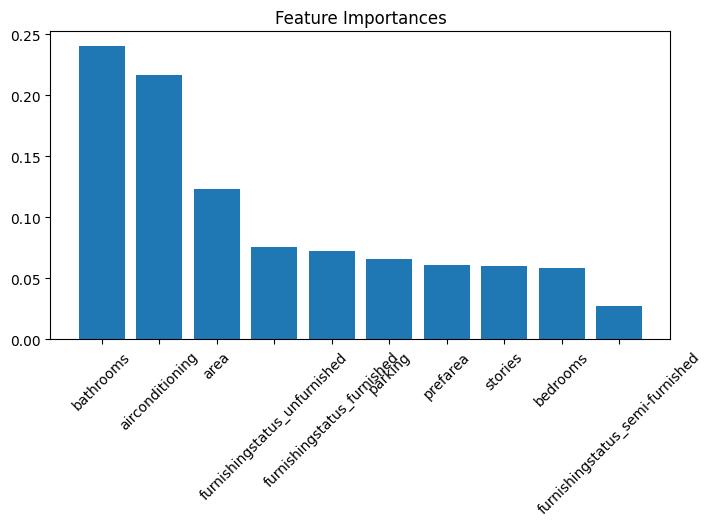

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already fit your model, e.g.:
# rf = RandomForestRegressor().fit(X_train, y_train)
# or
# xgb = XGBRegressor().fit(X_train, y_train)

def plot_feature_importances(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8,4))
    plt.title("Feature Importances")
    plt.bar(range(top_n), importances[indices], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45)
    plt.show()

# Example usage:
plot_feature_importances(models[1], X_train.columns)
plot_feature_importances(models[3], X_train.columns)